In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/santander-kaggle/train.csv')
sub = pd.read_csv('../data/santander-kaggle/sample_submission.csv')

In [3]:
df.index = df.ID_code
df = df.drop(['ID_code'], axis=1)

# Basic SKLearn modeling

In [4]:
# Just run a Rnadom Forest Classifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [5]:
# standardize DF
def standardize_data(df):
    features = df.select_dtypes(float).columns
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)
    df_std['target'] = df.target
    return df_std

In [23]:
df_std = standardize_data(df)

In [6]:
traindf, testdf = train_test_split(df, test_size=0.1)
train_x = traindf.drop(['target'],axis=1)
train_y = traindf.target
test_x = testdf.drop(['target'],axis=1)
test_y = testdf.target

In [62]:
top_features = ['var_81', 'var_139', 'var_6', 'var_110', 'var_12', 'var_146', 'var_76', 'var_26', 'var_148', 'var_21', 'var_2', 'var_53', 'var_99', 'var_80', 'var_22', 'var_190', 'var_174', 'var_0', 'var_198', 'var_133', 'var_44', 'var_165', 'var_166', 'var_149', 'var_115', 'var_13', 'var_179', 'var_192', 'var_169', 'var_184', 'var_109', 'var_40', 'var_67', 'var_191', 'var_34', 'var_170', 'var_1', 'var_9', 'var_78', 'var_123', 'var_86', 'var_154', 'var_92', 'var_95', 'var_94', 'var_172', 'var_108', 'var_36', 'var_122', 'var_173']

In [25]:
#model = RandomForestClassifier(n_estimators=50, max_depth=8, max_features=0.1)
#model = DecisionTreeClassifier(max_depth=8, max_features)
model = GaussianNB()

In [66]:
scores = cross_validate(model, train_x, train_y, cv=3, scoring='roc_auc')

In [67]:
scores

{'fit_time': array([0.80330658, 0.78830647, 0.97417855]),
 'score_time': array([0.38356614, 0.38800335, 0.45505023]),
 'test_score': array([0.88761009, 0.88855929, 0.88771192])}

In [29]:
%time model.fit(train_x, train_y)

Wall time: 1.03 s


GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
actual_y = testdf.target
predicted_y = model.predict(testdf.drop(['target'], axis=1))
predicted_y_prob = model.predict_proba(testdf.drop(['target'], axis=1))

In [18]:
print(roc_auc_score(actual_y, predicted_y_prob[:,1]))
print(roc_auc_score(actual_y, predicted_y))

0.8900260991686333
0.6690327946019496


In [19]:
model.get_params()

{'priors': None, 'var_smoothing': 1e-09}

# Many Small Trees

In [57]:
from scipy.special import logit, expit

In [157]:
models = []
for var in train_x.columns:
    model = DecisionTreeClassifier(min_samples_leaf=0.05)
    model.fit(train_x[var].values.reshape(-1,1), train_y)
    models.append(model)

In [158]:
predictions1 = [m.predict_proba(x.reshape(-1,1))[:,1] for (m, x) in zip(models, test_x.values.T)]
df_pred1 = pd.DataFrame(np.array(predictions1).T)

In [181]:
np.linspace(0.01,0.2,20)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [173]:
logit(np.array(predictions1).T).sum(axis=1)


array([-439.03121751, -439.18925922, -443.54007284, ..., -440.35819081,
       -439.66428607, -440.96660864])

In [172]:
pred_y_logit

array([-439.03121751, -439.18925922, -443.54007284, ..., -440.35819081,
       -439.66428607, -440.96660864])

In [159]:
pred_y = df_pred1.mean(axis=1).values
pred_y_logit = (logit(df_pred1).sum(axis=1).values)

In [160]:
print(roc_auc_score(test_y, pred_y))
print(roc_auc_score(test_y, pred_y_logit))

0.8875783762891294
0.8842509929750093


In [149]:
a = expit(df_pred1.apply(logit).sum(axis=1))
b = expit(df_pred0.apply(logit).sum(axis=1))

In [162]:
res = pd.DataFrame()

In [163]:
res['predicted_1'] = a
res['predicted_0'] = b

In [80]:
from sklearn.tree import plot_tree

In [137]:
var = 'var_3'
model = DecisionTreeClassifier(min_samples_leaf=0.1)
model.fit(train_x[var].values.reshape(-1,1), train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [136]:
predy = model.predict_proba(test_x[var].values.reshape(-1,1))[:,1]
predy2 = models[3].predict_proba(test_x[var].values.reshape(-1,1))[:,1]
print(roc_auc_score(test_y, predy))
print(roc_auc_score(test_y, predy2))

0.5003498865977445
0.49974021783499856


[Text(237.5044892471814, 216.81874285714287, 'X[0] <= 14.67\ngini = 0.181\nsamples = 180000\nvalue = [161851, 18149]'),
 Text(166.42330283193724, 215.57622857142857, 'X[0] <= 11.906\ngini = 0.173\nsamples = 166761\nvalue = [150788, 15973]'),
 Text(127.82747402345471, 214.33371428571428, 'X[0] <= 11.388\ngini = 0.163\nsamples = 119581\nvalue = [108900, 10681]'),
 Text(85.5504050595729, 213.0912, 'X[0] <= 9.838\ngini = 0.162\nsamples = 108382\nvalue = [98773, 9609]'),
 Text(20.298555881459027, 211.84868571428572, 'X[0] <= 9.838\ngini = 0.164\nsamples = 72228\nvalue = [65697, 6531]'),
 Text(13.942465071500044, 210.60617142857143, 'X[0] <= 5.133\ngini = 0.164\nsamples = 72223\nvalue = [65695, 6528]'),
 Text(1.3073454930807353, 209.36365714285714, 'X[0] <= 5.03\ngini = 0.135\nsamples = 1048\nvalue = [972, 76]'),
 Text(1.0670283193967718, 208.12114285714284, 'X[0] <= 5.026\ngini = 0.153\nsamples = 877\nvalue = [804, 73]'),
 Text(0.7549671878071573, 206.87862857142858, 'X[0] <= 4.804\ngini = 

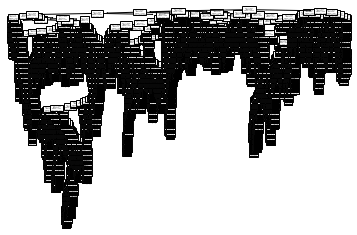

In [81]:
plot_tree(mod2)

In [180]:
res[res.predicted_1<0.1].shape

(179950, 2)

In [181]:
train_y.sum()

18047

In [39]:
for var in train_x.columns:
    stats = train_x[var].append(test_x[var]).value_counts()
    hist = pd.DataFrame()
    hist[var] = pd.Series(test_x[var]).map(stats)
    hist[var] = hist[var] > 1

ind = hist.sum(axis=1) != 200

In [40]:
var_stats = {var:train_x[var].append(test_x[ind][var]).value_counts() for var in train_x.columns}

In [52]:
var = 'var_0'
a = train_x[var].values.reshape(-1,1)
b = train_x[var].map(var_stats[var]).values.reshape(-1,1)
np.hstack([a,b]).shape

(180000, 2)

# Make prediction

In [43]:
import datetime

In [60]:
def timestamp():
    now = datetime.datetime.now()
    return "{}-{}-{}_{}-{}".format(now.year, now.month, now.day, now.hour, now.minute)

In [61]:
def predict_kaggle():
    test_data = pd.read_csv('../data/santander-kaggle/test.csv')
    test_data.index = test_data.ID_code
    test_data = test_data.drop(['ID_code'], axis=1)
    output = pd.DataFrame(model.predict_proba(test_data)[:, 1], columns=['target'], index=test_data.index)
    output.to_csv('outputs/gaussianNB_{}.csv'.format(timestamp()))

# Improve engineering

In [69]:
df.corr()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


# PDF modeling

In [5]:
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [124]:
def pure_kdes(df, variable_name):
    kde1 = (stats.gaussian_kde(df[df.target==1][variable_name]))
    kde0 = (stats.gaussian_kde(df[df.target==0][variable_name]))
    return kde1, kde0 

In [123]:
def compute_kdes(df, variable_name, plot=True):
    kde1, kde0 = pure_kdes(df, variable_name)
    a = np.floor(df[variable_name].min())
    b = np.ceil(df[variable_name].max())
    xs = np.linspace(a,b,100)
    
    y1 = kde1(xs)
    y0 = kde0(xs)
    
    if (plot):
        sns.lineplot(xs, kde1(xs))
        sns.lineplot(xs, kde0(xs))

    return (y0, y1, kde0, kde1, xs)

In [130]:
top50_features

Int64Index([ 81, 139,   6, 110,  12, 146,  76,  26, 148,  21,   2,  53,  99,
             80,  22, 190, 174,   0, 198, 133,  44, 165, 166, 149, 115,  13,
            179, 192, 169, 184, 109,  40,  67, 191,  34, 170,   1,   9,  78,
            123,  86, 154,  92,  95,  94, 172, 108,  36, 122, 173],
           dtype='int64')

In [134]:
selected_features = ['var_{}'.format(x) for x in top50_features]

In [151]:
vector = df_std[selected_features].loc['train_0']

In [152]:
kde(0.1)[0]

0.3575471433409662

In [159]:
from scipy.special import logit, expit

In [178]:
[kde0(0.5), kde1(0.5)]


[array([0.35077386]), array([0.34269783])]

In [166]:
a = (logit([kde(x)[0] for (x, kde) in (zip(vector, kde0s))]).sum())
b = (logit([kde(x)[0] for (x, kde) in (zip(vector, kde1s))]).sum())

In [173]:
b/a

1.0874566586771919

In [131]:
kde0s = []
kde1s = []
for feature in top50_features:
    var = 'var_{}'.format(feature)
    kde1, kde0 = pure_kdes(df_std, var)
    kde0s.append(kde0)
    kde1s.append(kde1)

var_81
var_139
var_6
var_110
var_12
var_146
var_76
var_26
var_148
var_21
var_2
var_53
var_99
var_80
var_22
var_190
var_174
var_0
var_198
var_133
var_44
var_165
var_166
var_149
var_115
var_13
var_179
var_192
var_169
var_184
var_109
var_40
var_67
var_191
var_34
var_170
var_1
var_9
var_78
var_123
var_86
var_154
var_92
var_95
var_94
var_172
var_108
var_36
var_122
var_173


In [82]:
df_std.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,-1.561580,-1.473796,...,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135,0
train_1,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,0.858974,0.419300,...,0.093605,0.443623,1.908764,-0.817594,1.522342,1.067654,-0.129400,0.825417,0.505685,0
train_2,-0.681113,-0.276066,0.516988,0.536516,-0.305477,-0.511033,1.769839,-0.564749,-1.561370,-1.307408,...,0.777997,-0.174131,-0.412316,1.151591,2.297370,-1.617906,-0.695141,-0.381449,0.356681,0
train_3,0.125158,-0.129426,-0.667575,0.195355,0.927992,0.410672,0.500633,-0.474201,-1.843910,0.548767,...,-0.891456,-0.818468,-0.478548,1.607869,-0.789517,-0.959020,1.501744,0.697118,-0.543502,0
train_4,-0.277303,0.035610,0.817683,-0.077829,0.738607,0.955574,0.613372,0.791544,1.794753,0.090006,...,0.688988,-1.405987,1.468536,-1.501101,-0.958473,0.297627,0.645537,0.706318,-0.525375,0


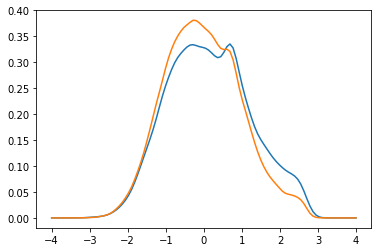

In [98]:
y0, y1, kde0, kde1, xs = compute_kdes(df_std, 'var_0', True)

In [92]:
kde = stats.gaussian_kde(df_std['var_0'])
xs = np.linspace(-4,4,100)
ys = kde(xs)

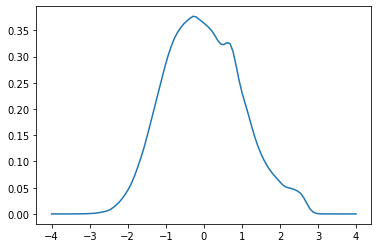

In [95]:
sns.lineplot(xs, ys)

In [99]:
np.trapz(y1, xs)

0.9999999993532849

In [100]:
np.trapz(y0, xs)

0.9999999999997913

In [101]:
# compute all kdes for all variables:
y0s = []
y1s = []
diffs = []
for var in features:
    y0, y1, kde0, kde1, xs = compute_kdes(df_std, var, False)
    y0s.append(np.trapz(y0, xs))
    y1s.append(np.trapz(y1, xs))
    diffs.append(np.trapz(np.abs(y1-y0), xs))
    print (var)

In [129]:
res = pd.DataFrame([y0s, y1s, diffs], index=['y0','y1','difference']).T
top50_features = res.sort_values(by='difference', ascending=False).head(50).index

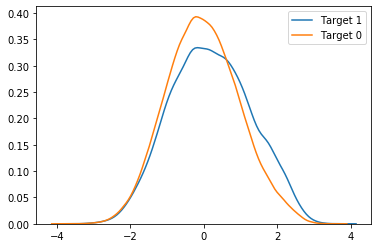

In [118]:
plot_kdes(df_std, 'var_110')

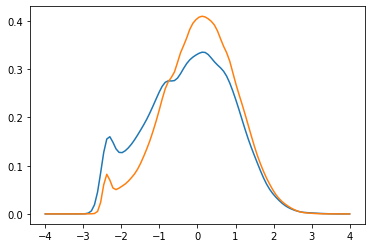

In [113]:
_ = compute_kdes(df_std, 'var_81')